/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_67504/3584942142.py:15: DtypeWarning: Columns (2,3,5,9,11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  policy_data = pd.read_csv('../DataFiles/2024-srcsc-superlife-inforce-dataset.csv')


36961

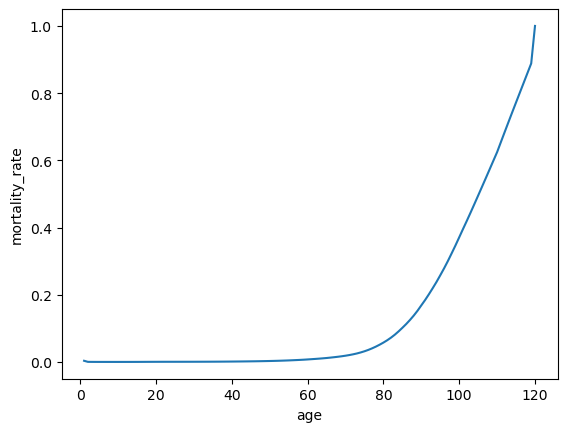

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


mr = pd.read_csv('../DataFiles/mortality_rate.csv')

sns.lineplot(data = mr, x = 'age', y = 'mortality_rate')

econ_data = pd.read_csv('../DataFiles/economic_data.csv')

econ_data

policy_data = pd.read_csv('../DataFiles/2024-srcsc-superlife-inforce-dataset.csv')

policy_data = policy_data.drop([0,1])
policy_data.index = range(0, policy_data.shape[0])
policy_data.columns = policy_data.iloc[0,:]
policy_data = policy_data.drop([0])

policy_data.columns = [c.replace('.','_').lower() for c in policy_data.columns]

policy_data.death_indicator.describe()

policy_data.death_indicator.value_counts().index

policy_data.death_indicator.shape[0]- sum([1 if i == 1 else 0 for i in policy_data.death_indicator.isna()])

policy_data.death_indicator.shape[0]- sum([0 if i == 1 else 1 for i in policy_data.death_indicator])

###### Data munging

In [4]:
policy_data.lapse_indicator.fillna(0)
policy_data.year_of_lapse[policy_data.lapse_indicator=='Y'].unique()
# a lapse indicator of 'Y' is also associated with a year of lapse. Fill w/ 1
policy_data.lapse_indicator[policy_data.lapse_indicator == 'Y'] = 1
policy_data.death_indicator = policy_data.death_indicator.fillna(0)
policy_data = policy_data.astype({'issue_year':'int', 'issue_age':'int',
    'face_amount':'int',  'year_of_death':'float', 'death_indicator': 'float',
    'year_of_lapse':'float', 'lapse_indicator': 'float', 'region':'int'})

# Convert variables to indicators and ordinals
policy_data = policy_data.convert_dtypes()
conversions = {'sex': {'F': 0, 'M': 1},
'underwriting_class': {'very low risk': 0, 'low risk': 1, 'moderate risk': 2,
'high risk': 3},
'urban_vs_rural': {'Urban': 0, 'Rural': 1},
'smoker_status': {'NS':0, 'S':1}}

for c in list(conversions.keys()):
    policy_data[c] = [conversions[c][val] for val in policy_data[c]]

# Derive data attributes
policy_data['age_at_death'] = policy_data['year_of_death'] - \
    policy_data['issue_year'] + policy_data['issue_age']
policy_data['age_at_lapse'] = policy_data['year_of_lapse'] - \
    policy_data['issue_year'] + policy_data['issue_age']

# determine number of years each policy was in effect
policy_data['years_in_effect'] = 0
policy_data.loc[policy_data.death_indicator == 1, 'years_in_effect'] = \
    policy_data.year_of_death - policy_data.loc[
        policy_data.death_indicator == 1, 'issue_year']

policy_data.loc[policy_data.lapse_indicator == 1,'years_in_effect'] = \
    policy_data.year_of_lapse - policy_data.loc[
        policy_data.lapse_indicator == 1, 'issue_year']

policy_data.loc[((policy_data.lapse_indicator != 1) & 
                  (policy_data.death_indicator != 1)), 'years_in_effect'] = \
     2023 - policy_data.loc[((policy_data.lapse_indicator != 1) & 
                  (policy_data.death_indicator != 1)),'issue_year']

# determine the maximum age attained or current age if still alive and active
# for each policyholder
policy_data['max_age'] = policy_data.years_in_effect + policy_data.issue_age

###### Data Investigation

In [42]:
class policy_stats:
    """collect statistics on the data"""
    def __init__(self, policy_data):
        self.min_age = policy_data.issue_age.min()
        self.max_age = policy_data.max_age.max()
        self.age_range = self.max_age - self.min_age
        self.max_year = policy_data.issue_year.max()
        self.min_year = policy_data.issue_year.min()

In [41]:
ps = policy_stats(policy_data)

([<matplotlib.axis.XTick at 0x7f9394f67520>,
 [Text(0, 0, '26'),
  Text(8, 0, '34'),
  Text(16, 0, '42'),
  Text(24, 0, '50'),
  Text(32, 0, '58'),
  Text(40, 0, '66'),
  Text(48, 0, '74'),
  Text(56, 0, '82')])

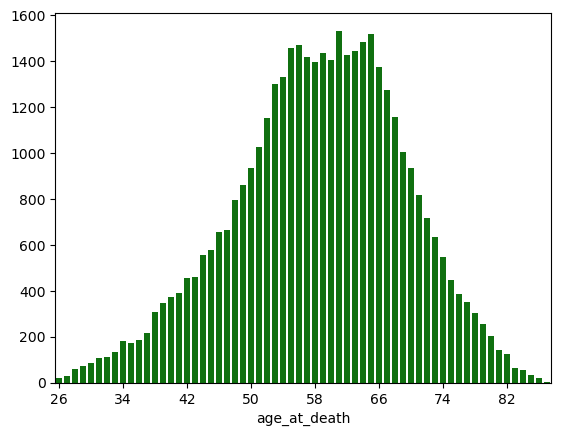

In [13]:
sns.barplot(x = policy_data['age_at_death'].value_counts().index, 
           y = policy_data['age_at_death'].value_counts().values, color = 'g')
plt.xticks(ticks = np.arange(0,88-26,8))

It is likely bimodal due to gender differences

No policies that have lapsed have death info. 

'''
policy_data[(policy_data.death_indicator == 1) &  
(policy_data.lapse_indicator == 1)]
'''

In [21]:
def num_lives(policies, age):
    """find the number of people who are alive and with a policy in effect at a 
    certain age"""
    return policies[(policies.max_age >= age) & 
                    (policies.issue_age <= age)].shape[0] 

In [22]:
def plot_age_stats(data, title, ylabel, policy_stats):
    """make a plot with 'Age' on x-axis and a response variable on the y-axis"""
    sns.barplot(x = data.index, y = data.values, color = 'lightgreen')
    plt.xticks(ticks = np.arange(0, policy_stats.max_age - policy_stats.min_age 
                                 + 1 , 10))
    plt.title(f'{title}')
    plt.xlabel('Age')
    plt.ylabel(f'{ylabel}')

In [43]:
plot_age_stats(life_counts, 'Number of Lives At Each Age', 'Number of Lives', ps)

NameError: name 'life_counts' is not defined

Trend in mortality rates
Overlay num deaths, num lives on mortality rate

In [ ]:
policy_data.age

In [45]:
def mortality_rate(policies):
    return pd.Series({age:
            policies.age_at_death.value_counts()[age]
            /num_lives(policies,age) for age in age_range})

In [102]:
mr = mortality_rate(policy_data);

In [23]:
def num_lives(policies, age, year):
    return policies[(policies.max_age >= age) & 
                    (policies.issue_age <= age) &
                    (policies.issue_year <= year) & 
                    (policies.max_year >= year)].shape[0]

In [44]:
def year_mortality(policies, age, year):
    return policies[(policies.max_age >= age) & 
                    (policies.issue_age <= age) &
                    (policies.issue_year <= year) & 
                    (policies.max_year >= year)].shape[0]

In [25]:
def mortality_by_year(policies, suppport):
    pd.DataFrame({year: mortality_rate[policies[]].
    return policies[(policies.max_age >= age) & 
                    (policies.issue_age <= age) &
                    (policies.issue_year <= year) & 
                    (policies.max_year >= year)].shape[0]

SyntaxError: invalid syntax (816380827.py, line 2)

In [26]:
plot_age_stats(mr, 'Mortality Rate by Age', 'Mortality Rate')

TypeError: plot_age_stats() missing 1 required positional argument: 'policy_stats'

In [109]:
policy_data['max_year'] = policy_data.issue_year + policy_data.years_in_effect

In [ ]:
for age in policy_data.age_at_death.value_counts().\
sort_index(ascending=False).values:
    mortality_rate = policy_data[(policy_data.age_at_death == age)].values/\
    (policy_data.issue_age

In [ ]:
policy_data[policy_data.issue_age >= 

In [ ]:
policy_data.

In [ ]:
max(policy_data['years_in_effect'].values)

In [ ]:
def policy_check(policy, death_lapse):
    policy.

find p_x_t, q_x_t

In [ ]:
policy_data.issue_age.max()

In [ ]:
max_age = policy_data.issue_age.max()
min_age = policy_data.issue_age.min()
bp = sns.barplot(x = policy_data.issue_age.value_counts().sort_index().index, 
           y= policy_data.issue_age.value_counts().sort_index().values,
           color = 'lightgreen')
bp.set_title('Counts of Issue Age')
bp.set_xticks(np.arange(4,max_age-min_age+1,5))

In [ ]:
policy_data['age_at_death'].value_counts().sort_index(ascending = False)

In [ ]:
policy_data['years_in_effect'].value_counts().sort_index()

In [ ]:
policy_data['age_max'] = policy_data.years_in_effect + policy_data.issue_age

In [ ]:
policy_data['age_max'].value_counts().sort_index(ascending=False)

In [ ]:
policy_data.

In [ ]:
def mort_table(policy_data = policy_data, max_yrs = 22):
    for i in range(0, max_yrs + 1):
        p_x_t_life
        p_x_t_no_lapse
        

<Axes: >

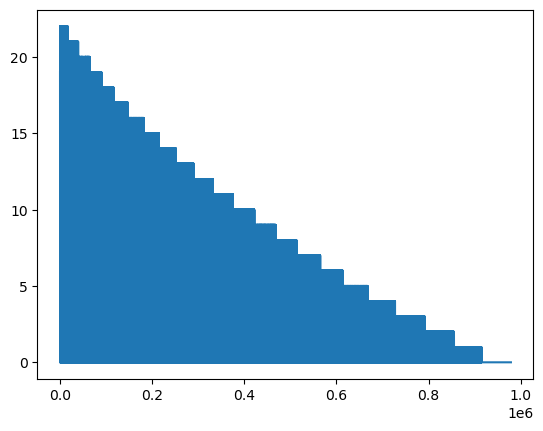

In [33]:
policy_data.years_in_effect.plot()

In [38]:
policy_data['year_of_death'].fillna(policy_data['year_of_lapse']).fillna(2023)[
np.minimum(policy_data['year_of_death'], policy_data['year_of_lapse']).notna()
]

Series([], dtype: Int64)

In [28]:
policy_data['years_in_effect'] = np.min(2023,
    np.min(policy_data['year_of_death'], policy_data['year_of_lapse'])) - \
    policy_data['issue_year']
    

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/7q/63cgxnn50sl5zwxkchv_j2cr0000gn/T/ipykernel_67504/584069087.py", line 2, in <module>
    np.min(policy_data['year_of_death'], policy_data['year_of_lapse'])) - \
  File "<__array_function__ internals>", line 200, in amin
  File "/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2946, in amin
    return _wrapreduction(a, np.minimum, 'min', axis, None, out,
  File "/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 84, in _wrapreduction
    return reduction(axis=axis, out=out, **passkwargs)
  File "/Users/williammohr/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py", line 11669, in min
    return NDFrame.min(self, axis, skipna, numeric_only, **kwargs)
 